In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle

from scripts.smdp_agent import SMDPQLearningAgent
from scripts.intraoption_agent import IntraOptionQLearningAgent
from scripts.taxi_utils import TaxiUtils as tu
from scripts.taxi_visualizer import TaxiVisualizer as tv
from scripts.taxi_visualizer import vis
from scripts.options import Option
from scripts.policies import MoveTaxiPolicy, EpsilonGreedyPolicy, OptimalPolicy, PickUpPassenger, DropOffPassenger, get_initiation_move_taxi, get_termination_move_taxi, get_termination_pick_passenger, get_termination_drop_passenger
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results, compute_decay

## Visualize Option set 1

- GoTo Red
- GoTo Green
- GoTo Yellow
- GoTo Blue

In [2]:
def vis_actions(actions, title):
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(title)
    tv.visualize_adjacency()
    tv.visualize_locations()
    tv.visualize_actions(actions)


    fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.gca().invert_yaxis()

    plt.tight_layout()

In [3]:
color_map = {tu.RED:"Red", tu.GREEN:"Green", tu.YELLOW:"Yellow", tu.BLUE:"Blue"}
options = [
    Option(index = i, 
           initiation_set = get_initiation_move_taxi(tu.COLOR_TO_LOC[color]), 
           policy = MoveTaxiPolicy(tu.COLOR_TO_LOC[color]), 
           termination = get_termination_move_taxi(tu.COLOR_TO_LOC[color]), 
           seed=0,
           label = f"Go To {color_map[color]}"
    )
    for i, color in enumerate([tu.BLUE, tu.YELLOW, tu.GREEN, tu.RED])
]
option1_labels = [option.label for option in options]

/tmp/ipykernel_5315/4291134353.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)


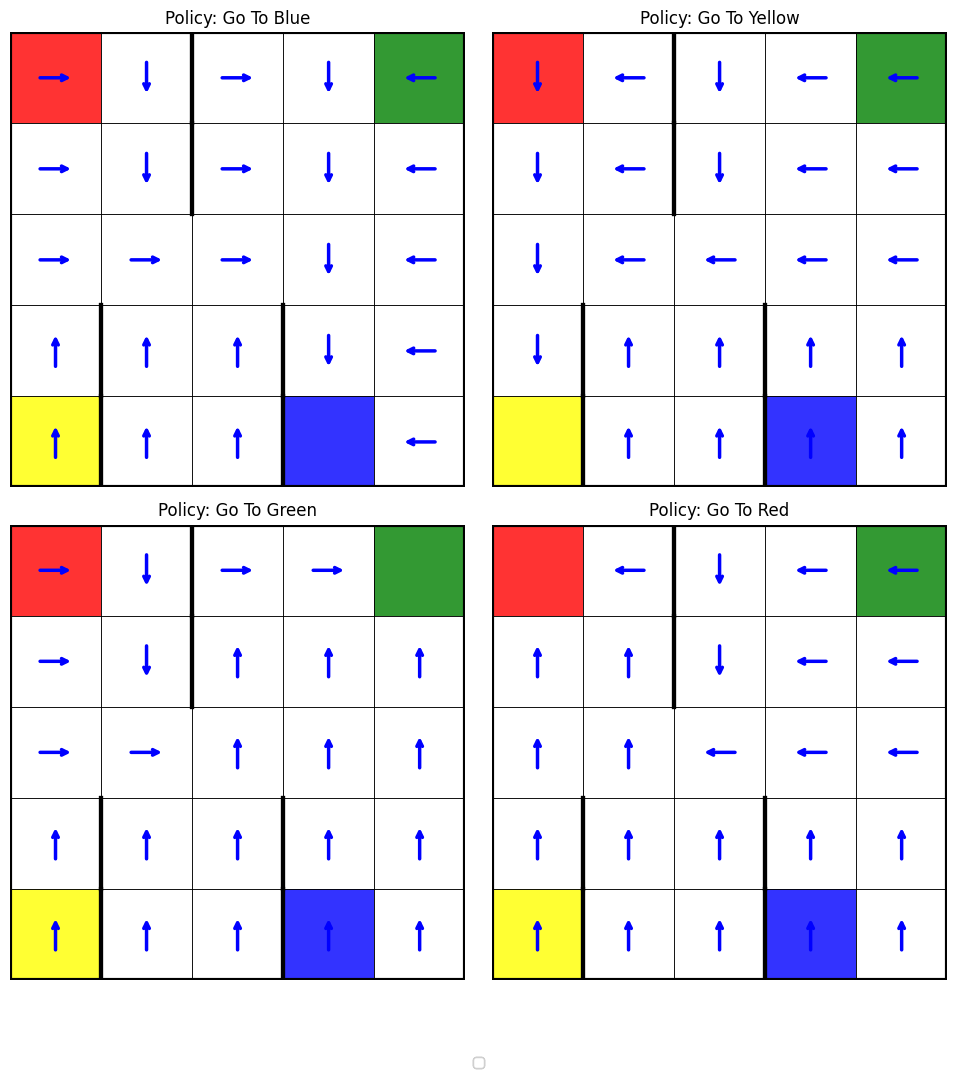

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, color in enumerate([tu.BLUE, tu.YELLOW, tu.GREEN, tu.RED]):
    actions = np.zeros((5, 5), dtype=np.int32)
    for taxi_row in range(5):
        for taxi_col in range(5):
            actions[taxi_row][taxi_col] = options[i].policy.act(
                tu.encode_env_state(taxi_row, taxi_col, tu.GREEN, tu.RED)
            )

    ax = axes[i // 2, i % 2]
    plt.sca(ax)
    vis_actions(actions, f"Policy: Go To {color_map[color]}")

plt.tight_layout()
plt.savefig("backups/option_set_1_policy.png")

## Visualize Option set 2

- PickUp Passenger
- DropOff Passenger

In [5]:
initiation_set = [True for i in range(500)]

options = [
    Option(0, initiation_set, PickUpPassenger(), get_termination_pick_passenger(), seed=0, label="Pick up Passenger"),
    Option(1, initiation_set, DropOffPassenger(), get_termination_drop_passenger(), seed=0, label="Drop off Passenger")
]
option2_labels = [option.label for option in options]

/tmp/ipykernel_5315/4291134353.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)


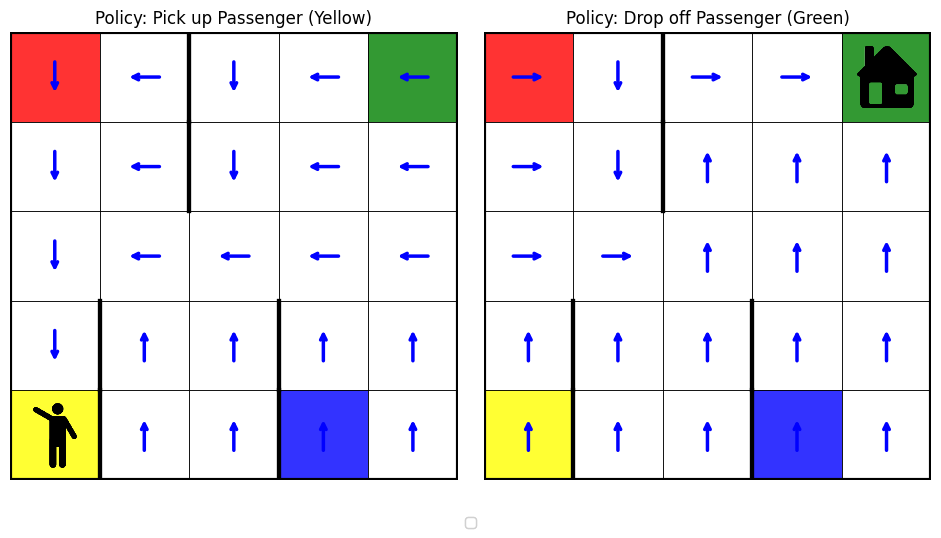

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
passenger_location = tu.YELLOW
destination = tu.GREEN

for i in range(2):
    actions = np.zeros((5, 5), dtype=np.int32)
    for taxi_row in range(5):
        for taxi_col in range(5):
            actions[taxi_row][taxi_col] = options[i].policy.act(
                tu.encode_env_state(taxi_row, taxi_col, passenger_location, destination)
            )

    ax = axes[i]
    plt.sca(ax)
    
    if i==0:
        vis_actions(actions, "Policy: " + options[i].label + f" ({color_map[passenger_location]})") 
        tv.visualize_passenger(tu.encode_env_state(3, 3, passenger_location, destination))
    else:
        vis_actions(actions, "Policy: " + options[i].label + f" ({color_map[destination]})") 
        tv.visualize_destination(tu.encode_env_state(3, 3, passenger_location, destination))

plt.tight_layout()
plt.savefig("backups/option_set_2_policy.png")

## Plot test results

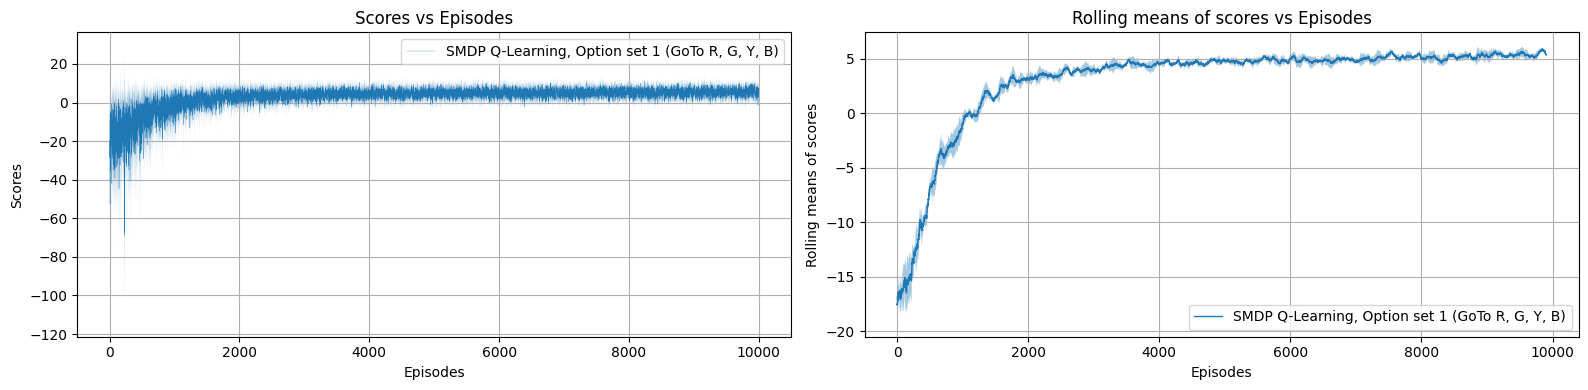

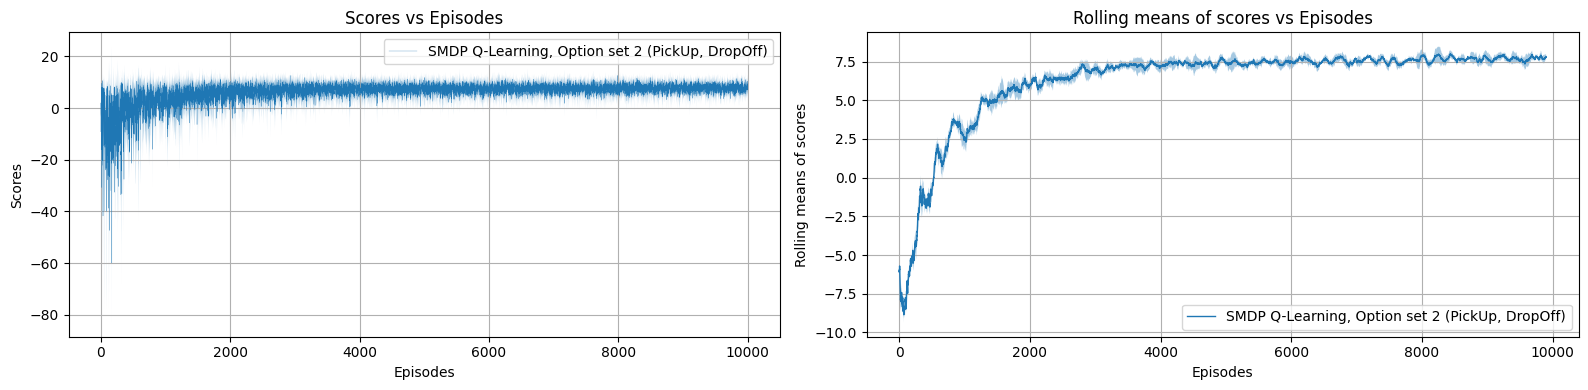

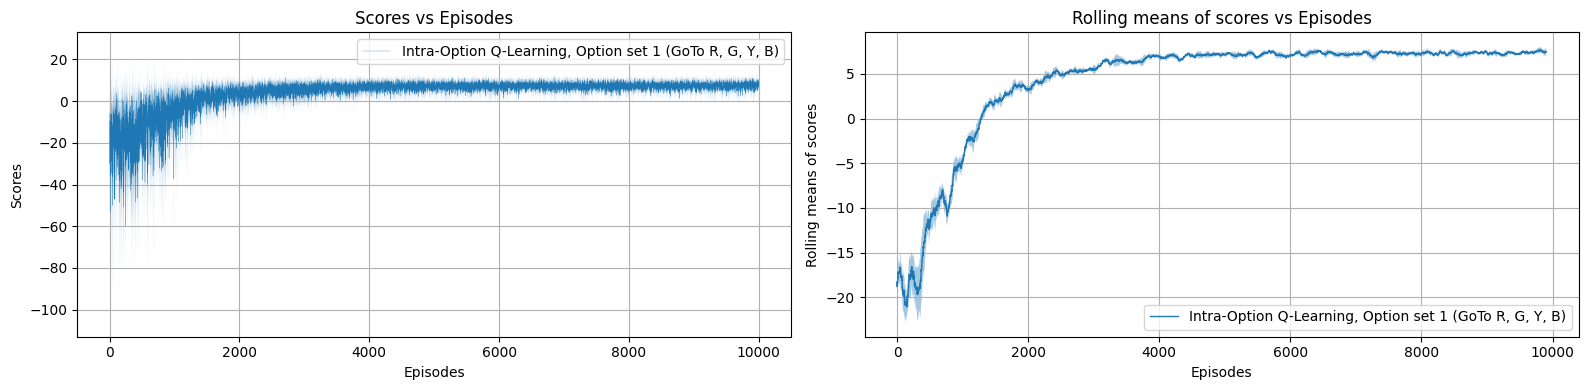

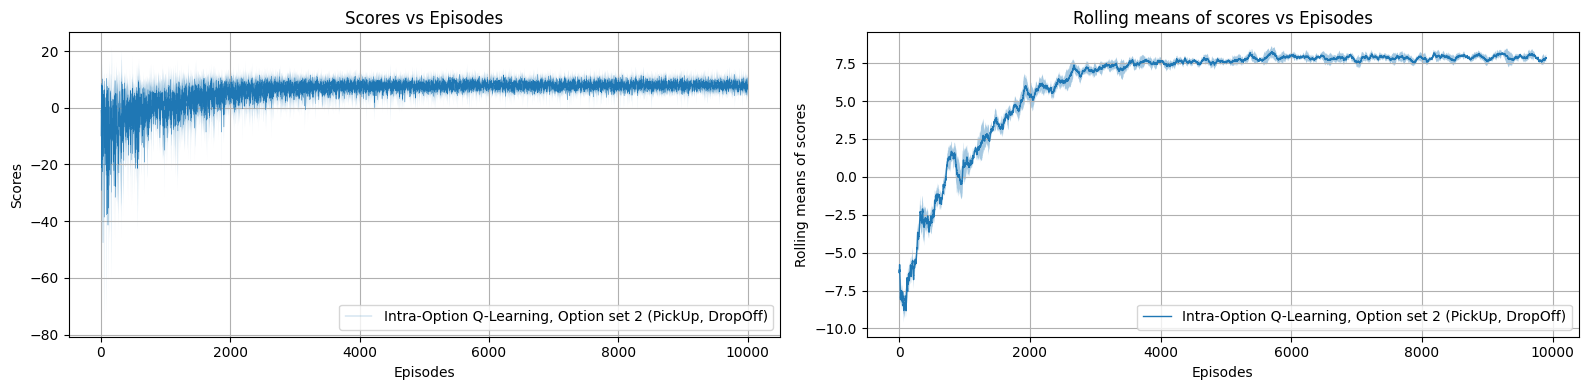

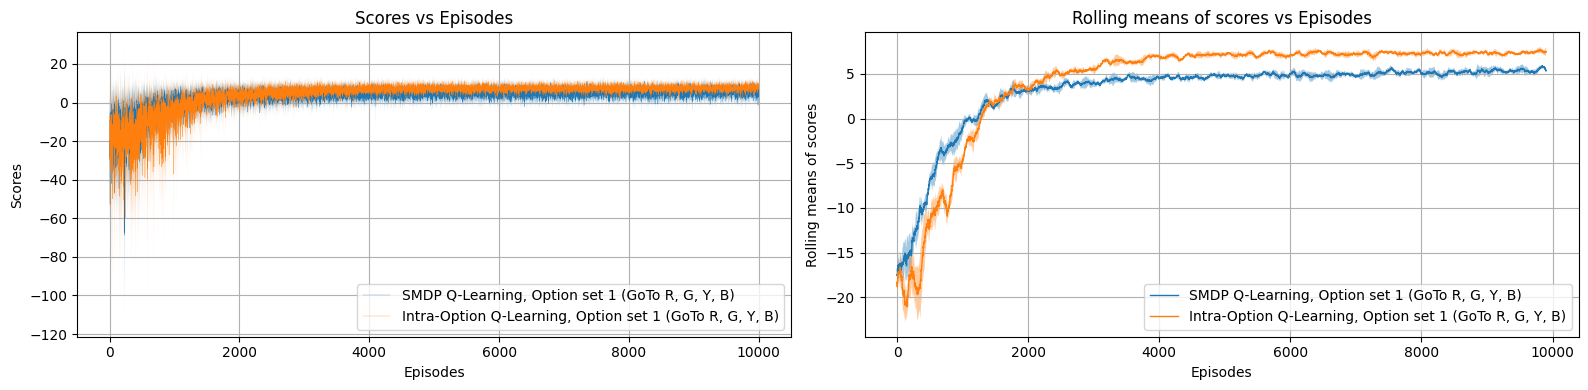

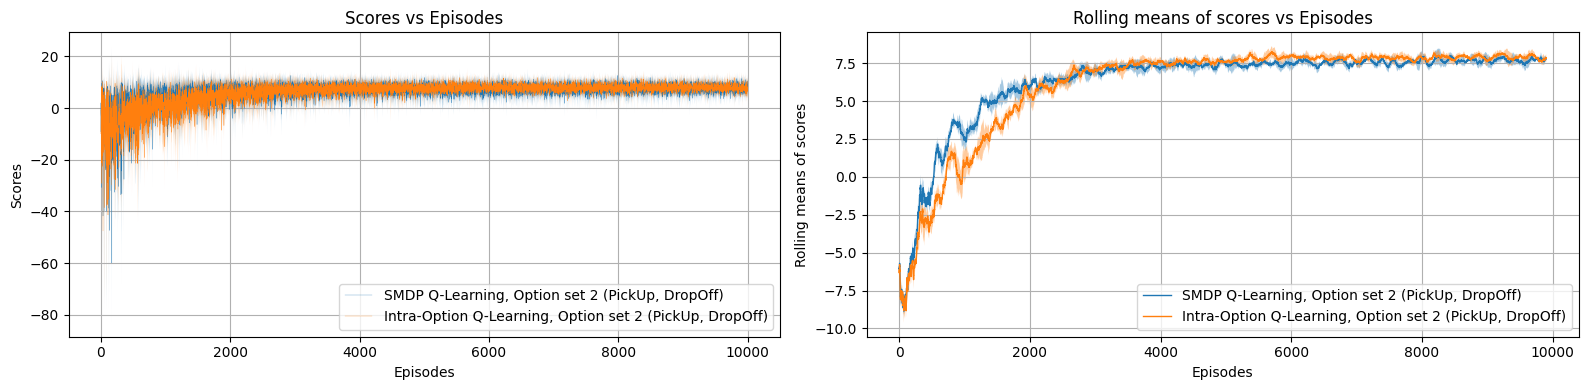

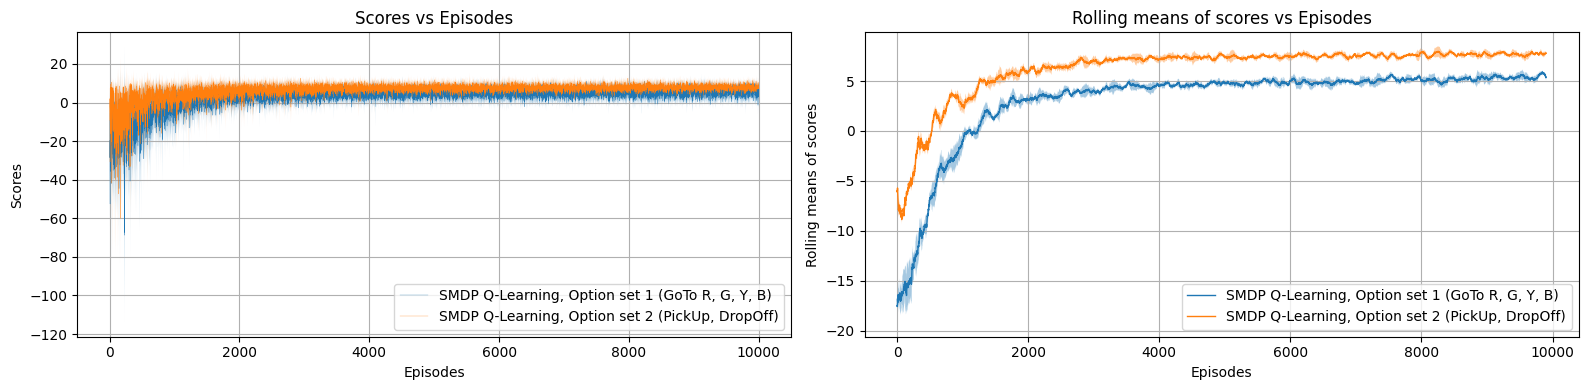

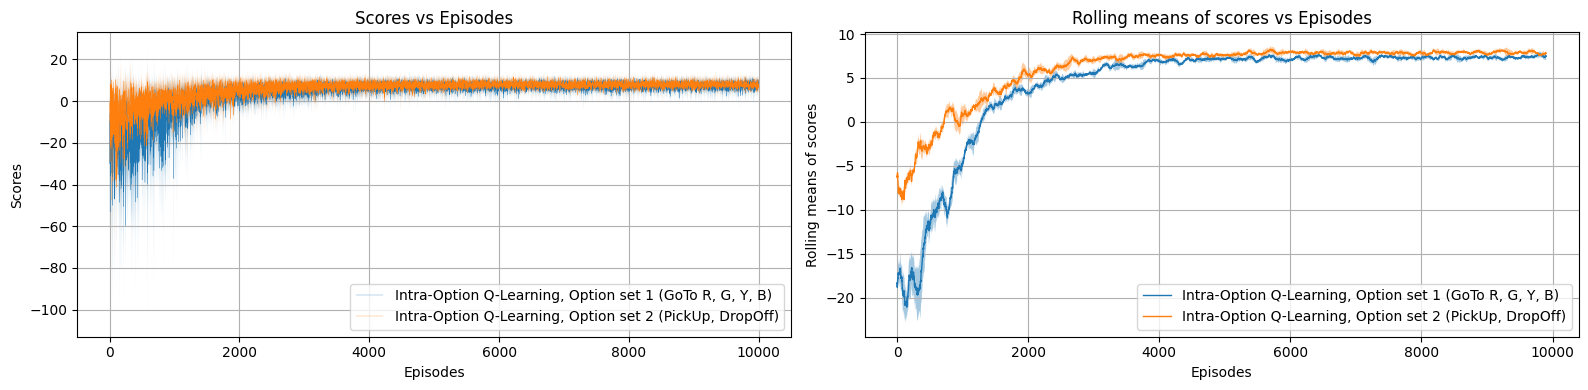

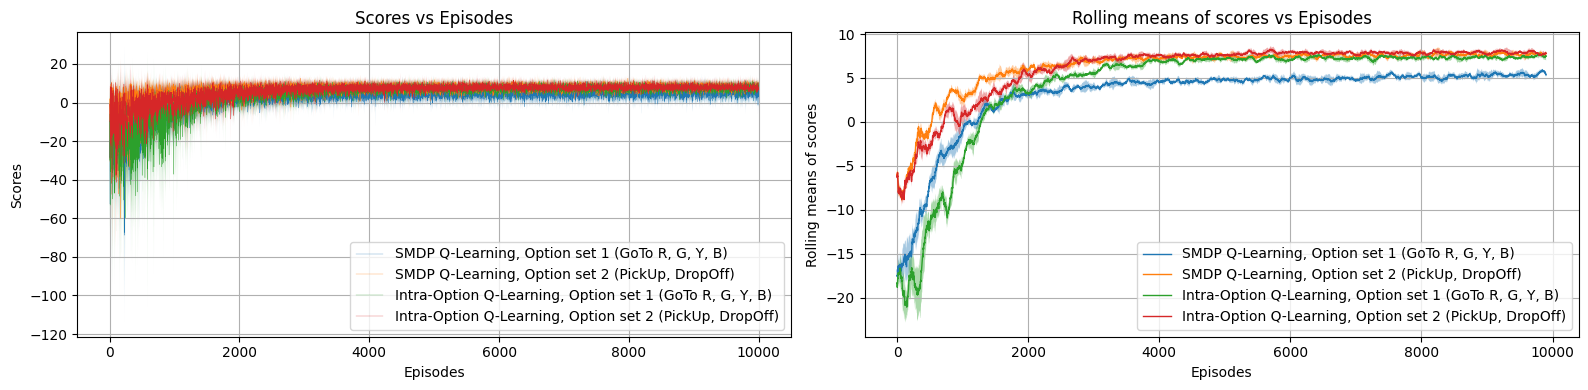

In [7]:
saved_files_results = {
    "smdp-option1": "backups/taxi-smdp-option1-plots/smdp_option_set_1_results.pickle",
    "smdp-option2": "backups/taxi-smdp-option2-plots/smdp_option_set_2_results.pickle",
    "intraoption-option1": "backups/taxi-intraoption-option1-plots/intraoption_option_set_1_results.pickle",
    "intraoption-option2": "backups/taxi-intraoption-option2-plots/intraoption_option_set_2_results.pickle",
}

descriptive_names = {
    "smdp-option1": "SMDP Q-Learning, Option set 1 (GoTo R, G, Y, B)",
    "smdp-option2": "SMDP Q-Learning, Option set 2 (PickUp, DropOff)",
    "intraoption-option1": "Intra-Option Q-Learning, Option set 1 (GoTo R, G, Y, B)",
    "intraoption-option2": "Intra-Option Q-Learning, Option set 2 (PickUp, DropOff)",   
}


results = {}

for key, filepath in saved_files_results.items():
    with open(filepath, "rb") as f:
        results[key] = pickle.load(f)
        results[key][0]["label"] = descriptive_names[key]

option_set_1_combined = results["smdp-option1"] + results["intraoption-option1"]
option_set_2_combined = results["smdp-option2"] + results["intraoption-option2"]
smdp_combined = results["smdp-option1"] + results["smdp-option2"]
intraoption_combined = results["intraoption-option1"] + results["intraoption-option2"]

all_results = smdp_combined + intraoption_combined


plot_test_results(smdp_combined, [0])
plt.savefig("backups/smdp_option_set_1.png")
plot_test_results(smdp_combined, [1])
plt.savefig("backups/smdp_option_set_2.png")
plot_test_results(intraoption_combined, [0])
plt.savefig("backups/intraoption_option_set_1.png")
plot_test_results(intraoption_combined, [1])
plt.savefig("backups/intraoption_option_set_2.png")

plot_test_results(option_set_1_combined, [0, 1])
plt.savefig("backups/option_set_1_combined.png")
plot_test_results(option_set_2_combined, [0, 1])
plt.savefig("backups/option_set_2_combined.png")
plot_test_results(smdp_combined, [0, 1])
plt.savefig("backups/smdp_combined.png")
plot_test_results(intraoption_combined, [0, 1])
plt.savefig("backups/intraoption_combined.png")
plot_test_results(all_results, [0, 1, 2, 3])
plt.savefig("backups/all_combined.png")

## Qtable visualizations

In [8]:
saved_files_qtable = {
    "smdp-option1": "backups/taxi-smdp-option1-plots/smdp_option_set_1_qtable.pickle",
    "smdp-option2": "backups/taxi-smdp-option2-plots/smdp_option_set_2_qtable.pickle",
    "intraoption-option1": "backups/taxi-intraoption-option1-plots/intraoption_option_set_1_qtable.pickle",
    "intraoption-option2": "backups/taxi-intraoption-option2-plots/intraoption_option_set_2_qtable.pickle",
}

qtables = {}

for key, filepath in saved_files_qtable.items():
    with open(filepath, "rb") as f:
        qtables[key] = pickle.load(f)
        qtables[key] = np.reshape(qtables[key], (5, 5, 5, 4, -1))



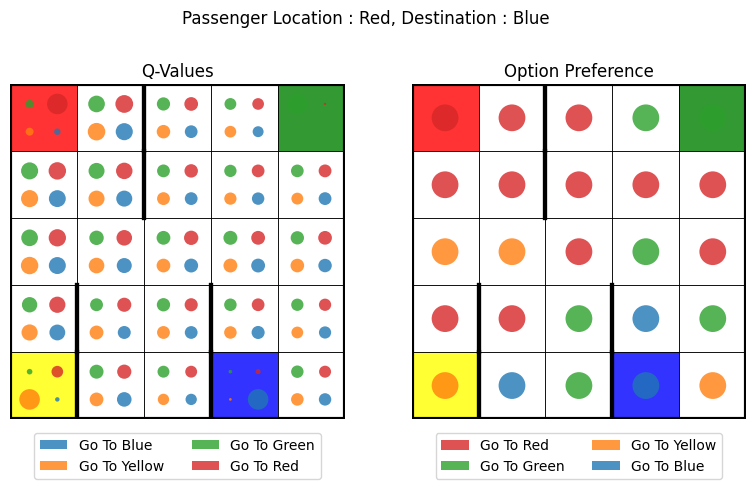

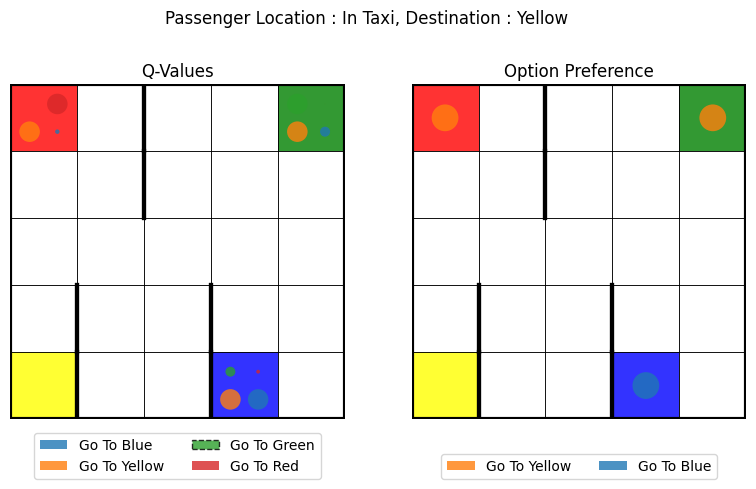

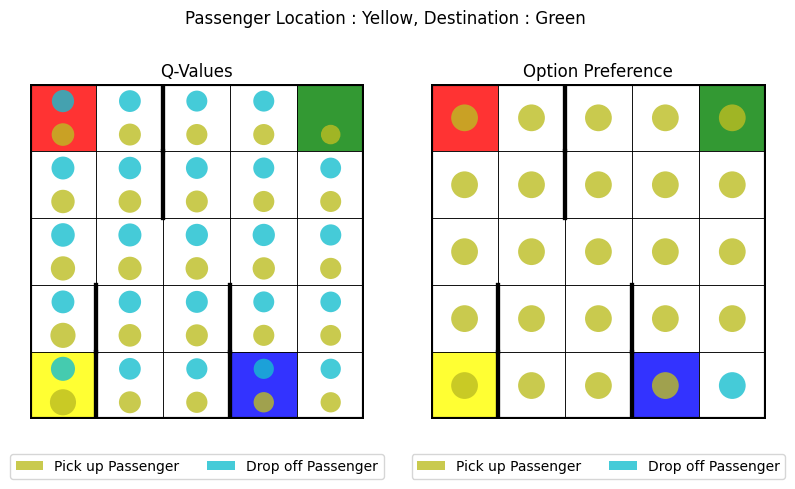

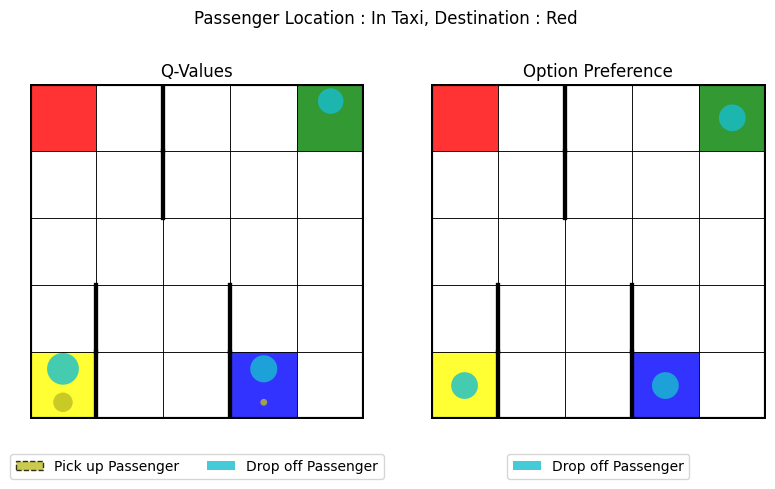

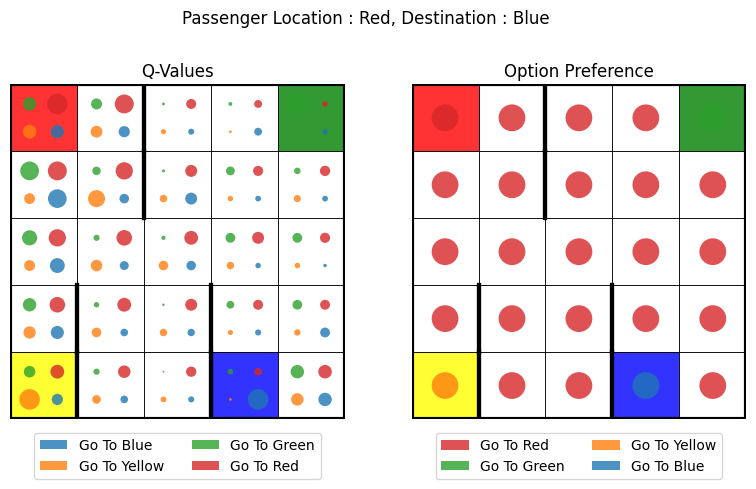

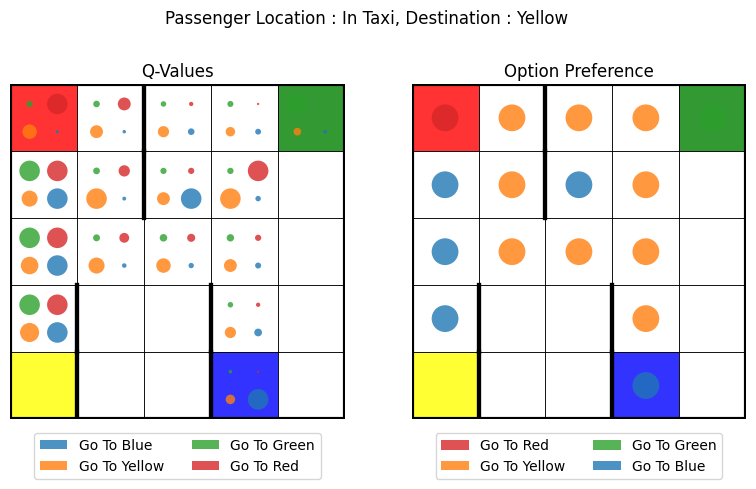

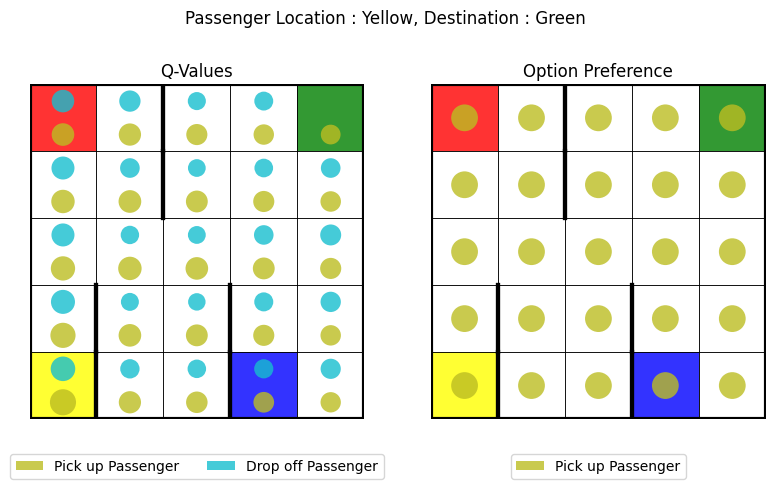

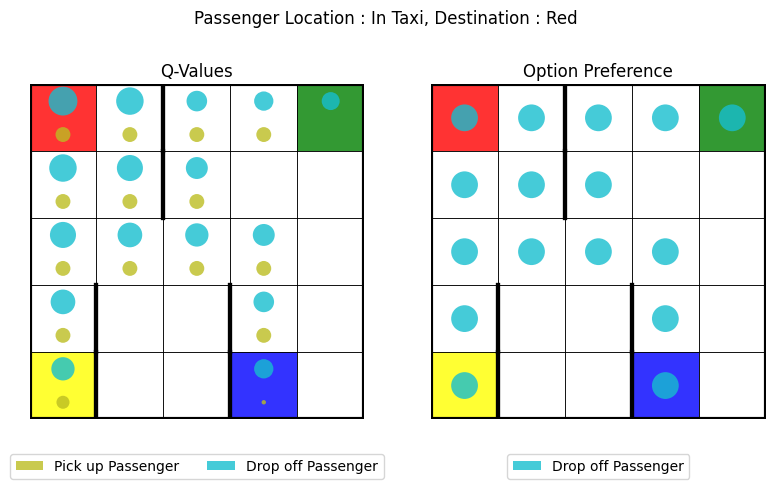

In [9]:
def vis2(state, Qtable, option_labels=None, color_offset=0):
    
    color_map = {tu.RED:"Red", tu.GREEN:"Green", tu.YELLOW:"Yellow", tu.BLUE:"Blue", tu.IN_TAXI:"In Taxi"}
    taxi_row, taxi_col, passenger_location, destination = tu.decode_env_state(state)
    
    fig, axs = plt.subplots(1, 2, figsize=(9.5, 5))
    fig.suptitle(f"Passenger Location : {color_map[passenger_location]}, Destination : {color_map[destination]}")
    
    # Left plot
    plt.sca(axs[0])
    tv.visualize_adjacency()
    tv.visualize_locations()
    option_values = Qtable[:,:,passenger_location, destination,:]
    tv.visualize_options_bubble_plot(option_values, option_labels, norm_axis=None, color_offset=color_offset)
    axs[0].legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
    axs[0].set_xlim(0, 5)
    axs[0].set_ylim(0, 5)
    axs[0].set_aspect("equal")
    axs[0].set_title("Q-Values")
    axs[0].axis("off")

    plt.gca().invert_yaxis()
    
    # Right plot
    plt.sca(axs[1])
    tv.visualize_adjacency()
    tv.visualize_locations()
    options = np.argmax(option_values, axis=-1)
    tv.visualize_options(options, option_values, option_labels, color_offset)
    axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
    axs[1].set_xlim(0, 5)
    axs[1].set_ylim(0, 5)
    axs[1].set_aspect("equal")
    axs[1].set_title("Option Preference")
    axs[1].axis("off")
    
    plt.gca().invert_yaxis()
    # plt.tight_layout()

## SMDP
vis2(tu.encode_env_state(3, 3, tu.RED, tu.BLUE), qtables["smdp-option1"], option1_labels, color_offset=0)
plt.savefig("backups/smdp_option_set_1_p1.png")
vis2(tu.encode_env_state(3, 3, tu.IN_TAXI, tu.YELLOW), qtables["smdp-option1"], option1_labels, color_offset=0)
plt.savefig("backups/smdp_option_set_1_p2.png")

vis2(tu.encode_env_state(3, 3, tu.YELLOW, tu.GREEN), qtables["smdp-option2"], option2_labels, color_offset=8)
plt.savefig("backups/smdp_option_set_2_p1.png")
vis2(tu.encode_env_state(3, 3, tu.IN_TAXI, tu.RED), qtables["smdp-option2"], option2_labels, color_offset=8)
plt.savefig("backups/smdp_option_set_2_p2.png")


## Intraoption
vis2(tu.encode_env_state(3, 3, tu.RED, tu.BLUE), qtables["intraoption-option1"], option1_labels, color_offset=0)
plt.savefig("backups/intraoption_option_set_1_p1.png")
vis2(tu.encode_env_state(3, 3, tu.IN_TAXI, tu.YELLOW), qtables["intraoption-option1"], option1_labels, color_offset=0)
plt.savefig("backups/intraoption_option_set_1_p2.png")

vis2(tu.encode_env_state(3, 3, tu.YELLOW, tu.GREEN), qtables["intraoption-option2"], option2_labels, color_offset=8)
plt.savefig("backups/intraoption_option_set_2_p1.png")
vis2(tu.encode_env_state(3, 3, tu.IN_TAXI, tu.RED), qtables["intraoption-option2"], option2_labels, color_offset=8)
plt.savefig("backups/intraoption_option_set_2_p2.png")

